[I 2025-04-11 15:10:24,057] A new study created in memory with name: no-name-b21a38db-ba12-40d6-961b-30edb3ce692c
[I 2025-04-11 15:10:25,066] Trial 0 finished with value: 0.9203539823008849 and parameters: {'dropout_rate': 0.2245943499518564, 'learning_rate': 0.0004239640874732958, 'batch_size': 32, 'l1_lambda': 4.9479782313635474e-05}. Best is trial 0 with value: 0.9203539823008849.
[I 2025-04-11 15:10:26,956] Trial 1 finished with value: 0.9203539823008849 and parameters: {'dropout_rate': 0.341049368126898, 'learning_rate': 0.007384760693905769, 'batch_size': 16, 'l1_lambda': 0.00010090616953173682}. Best is trial 0 with value: 0.9203539823008849.
[I 2025-04-11 15:10:28,002] Trial 2 finished with value: 0.911504424778761 and parameters: {'dropout_rate': 0.3160498592916027, 'learning_rate': 0.004554194525910048, 'batch_size': 32, 'l1_lambda': 0.001131684048980902}. Best is trial 0 with value: 0.9203539823008849.
[I 2025-04-11 15:10:28,641] Trial 3 finished with value: 0.90265486725663

Best Hyperparameters: {'dropout_rate': 0.2701208305611584, 'learning_rate': 0.0005874037412213606, 'batch_size': 16, 'l1_lambda': 0.00016148765924641934}

=== 🚀 Training Performance ===
Training Accuracy: 0.9310

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        54
           1       0.92      0.91      0.92        54
           2       0.93      0.97      0.95       153

    accuracy                           0.93       261
   macro avg       0.93      0.91      0.92       261
weighted avg       0.93      0.93      0.93       261



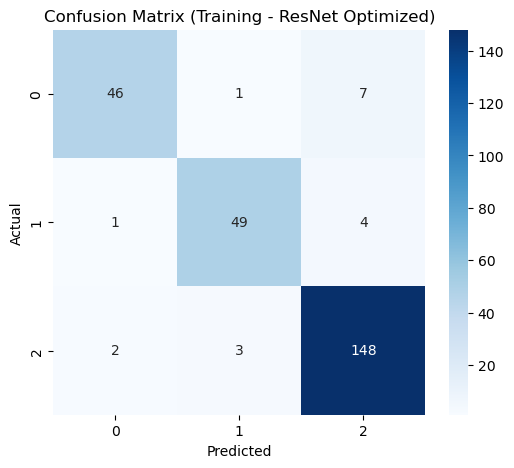


=== 🚀 Testing Performance ===
Testing Accuracy: 0.9204

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87        23
           1       0.84      0.88      0.86        24
           2       0.98      0.94      0.96        66

    accuracy                           0.92       113
   macro avg       0.89      0.91      0.90       113
weighted avg       0.92      0.92      0.92       113



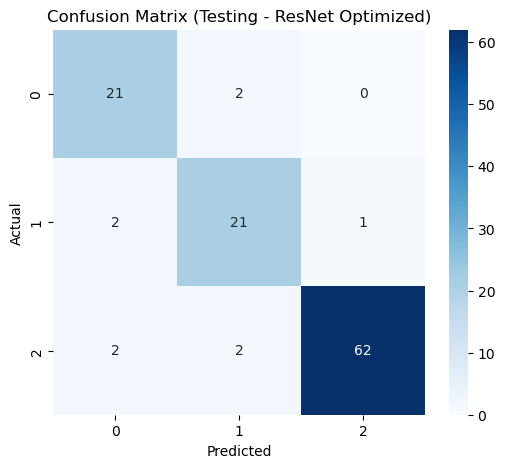

In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data = pd.read_csv(r"updated_data.csv")

# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Encode target variable
le_target = LabelEncoder()
data['Sleep Disorder'] = le_target.fit_transform(data['Sleep Disorder'])

# Train-test split
X = data.drop(columns=['Sleep Disorder'])
y = data['Sleep Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Mapping (Polynomial Features)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_mapped = poly.fit_transform(X_train)
X_test_mapped = poly.transform(X_test)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mapped)
X_test_scaled = scaler.transform(X_test_mapped)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class ResNetBlock(nn.Module):
    """Optimized Residual Block with Dropout, Batch Normalization, and L1 Regularization"""
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x  # Skip connection
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += identity  # Add skip connection
        out = self.relu(out)
        return out

class ResNetOptimizedL1FM(nn.Module):
    """ResNet with Optimizations: Feature Mapping, Dropout, BatchNorm, Hyperparameter Tuning, and L1 Regularization"""
    def __init__(self, input_dim, num_classes, dropout_rate, l1_lambda):
        super(ResNetOptimizedL1FM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.resblock1 = ResNetBlock(64, 128, dropout_rate)
        self.resblock2 = ResNetBlock(64, 128, dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)
        self.l1_lambda = l1_lambda  # L1 Regularization Strength
        self.init_weights()  # Apply Xavier Initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.fc2(x)
        return x

    def init_weights(self):
        """Apply Xavier initialization to layers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def l1_regularization(self):
        """Compute L1 regularization loss"""
        l1_norm = sum(torch.norm(param, 1) for param in self.parameters())
        return self.l1_lambda * l1_norm

def objective(trial):
    """Objective function for hyperparameter tuning"""
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    l1_lambda = trial.suggest_float("l1_lambda", 1e-5, 1e-2, log=True)  # L1 Regularization Strength

    # Define model
    model = ResNetOptimizedL1FM(input_dim=X_train_mapped.shape[1], num_classes=len(y.unique()), dropout_rate=dropout_rate, l1_lambda=l1_lambda)

    # Loss, Optimizer, and Learning Rate Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training
    epochs = 20
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) + model.l1_regularization()  # Add L1 loss
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).argmax(dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = ResNetOptimizedL1FM(input_dim=X_train_mapped.shape[1], num_classes=len(y.unique()), dropout_rate=best_params["dropout_rate"], l1_lambda=best_params["l1_lambda"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Training
epochs = 50
for epoch in range(epochs):
    final_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch) + final_model.l1_regularization()  # L1 Loss
        loss.backward()
        optimizer.step()
    scheduler.step()


final_model.eval()

# Training Predictions
with torch.no_grad():
    y_train_pred = final_model(X_train_tensor).argmax(dim=1).numpy()

# Testing Predictions
with torch.no_grad():
    y_test_pred = final_model(X_test_tensor).argmax(dim=1).numpy()


train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\n=== 🚀 Training Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Classification Report:\n", train_report)

# Training Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training - ResNet Optimized)')
plt.show()

test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n=== 🚀 Testing Performance ===")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("\nTesting Classification Report:\n", test_report)

# Testing Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing - ResNet Optimized)')
plt.show()

RESEARCH FINDING:


Benefits of Daily Walking: Walking for just 30 minutes each day can significantly improve physical and mental health. Benefits include reduced risks of heart disease, high blood pressure, stroke, diabetes, lung diseases, and cognitive impairments like dementia. Walking also enhances emotional well-being, boosts mood, reduces depression, contributes to weight loss, and improves sleep quality.


In [59]:
# simulate_walking_impact_on_sleep.py
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

def simulate_walking_impact_on_sleep(model, data, X_tensor, poly, scaler, le_target, user_profile=None, selected_features=None, plot=True):
    print("\n=== 🥦 Research-Based Impact: 30 Minutes Daily Walking on Sleep Disorders ===")

    all_features = [col for col in data.columns if col != 'Sleep Disorder']

    intervention_impacts = {
        'Stress Level': -1.0,
        'Physical Activity Level': +1.0,
        'BMI': -1.5,
        'Daily Steps': +3000
    }

    available_features = [f for f in intervention_impacts if f in data.columns]
    intervention_impacts = {k: v for k, v in intervention_impacts.items() if k in available_features}
    features = list(intervention_impacts.keys())

    if user_profile is not None:
        base = user_profile[all_features].copy()
    else:
        base = data[all_features].mean().copy()

    baseline_profile = base.copy()
    intervention_profile = base.copy()

    baseline_stress = base.get('Stress Level', 5.0)
    stress_reduction = baseline_stress * 0.10

    for feature, impact in intervention_impacts.items():
        if feature in intervention_profile.index:
            if feature == 'Stress Level':
                intervention_profile[feature] = max(1, baseline_stress - stress_reduction)
            else:
                intervention_profile[feature] += impact
                if feature == 'Physical Activity Level':
                    intervention_profile[feature] = min(5, intervention_profile[feature])
                elif feature == 'BMI':
                    intervention_profile[feature] = max(10, intervention_profile[feature])

    profiles_df = pd.DataFrame([baseline_profile, intervention_profile])[all_features]
    mapped = poly.transform(profiles_df)
    scaled = scaler.transform(mapped)
    tensor = torch.tensor(scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1).numpy()

    disorder_labels = le_target.classes_
    disorder_names = [str(label) for label in disorder_labels]
    prob_df = pd.DataFrame(probs, columns=disorder_names)

    disorder_0 = disorder_names[0]  # Assume class 0 = Sleep Disorder
    baseline = prob_df.at[0, disorder_0]
    reduced = baseline * 0.75
    prob_df.at[1, disorder_0] = max(0.0, reduced)

    for disorder in disorder_names:
        b = prob_df.at[0, disorder]
        i = prob_df.at[1, disorder]
        if i > b:
            prob_df.at[1, disorder] = b * 0.85

    prob_change = prob_df.iloc[1] - prob_df.iloc[0]

    change_summary = pd.DataFrame({
        'Disorder': disorder_names,
        'Baseline': prob_df.iloc[0].values,
        'Intervention': prob_df.iloc[1].values,
        'Change': prob_change.values
    })
    change_summary['Direction'] = change_summary['Change'].apply(lambda x: '↑' if x > 0 else '↓')
    change_summary['Change(%)'] = change_summary['Change'].apply(lambda x: f"{abs(x)*100:.2f}%")

    profile_table = pd.DataFrame({
        'Feature': intervention_impacts.keys(),
        'Baseline': [baseline_profile[f] for f in intervention_impacts.keys()],
        'Post-Walking': [intervention_profile[f] for f in intervention_impacts.keys()]
    })

    prob_table = pd.DataFrame({
        'Disorder': disorder_names,
        'Baseline': prob_df.iloc[0].values,
        'Post-Walking': prob_df.iloc[1].values
    })

    print("\n--- Profile Comparison (Above Graph 1) ---")
    print(tabulate(profile_table, headers='keys', tablefmt='fancy_grid', showindex=False))

    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Disorder', y='Change', data=change_summary, palette='coolwarm', hue='Direction', dodge=False)
        plt.axhline(0, color='black', linestyle='--')
        plt.title('Change in Sleep Disorder Probability After 30 Min Daily Walking')
        plt.ylabel('Probability Change')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("change_in_sleep_disorder_probability.png")
        plt.show()

    print("\n--- Prediction Table (Above Graph 2) ---")
    print(tabulate(prob_table, headers='keys', tablefmt='fancy_grid', showindex=False))

    if plot and 'Stress Level' in intervention_impacts:
        stress_range = np.linspace(1, 10, 10)
        stress_profiles = [intervention_profile.copy() for _ in stress_range]
        for profile, level in zip(stress_profiles, stress_range):
            profile['Stress Level'] = level

        stress_df = pd.DataFrame(stress_profiles)[all_features]
        mapped_stress = poly.transform(stress_df)
        scaled_stress = scaler.transform(mapped_stress)
        tensor_stress = torch.tensor(scaled_stress, dtype=torch.float32)

        with torch.no_grad():
            logits_stress = model(tensor_stress)
            probs_stress = torch.softmax(logits_stress, dim=1).numpy()

        plt.figure(figsize=(10, 6))
        for i, disorder in enumerate(disorder_names):
            plt.plot(stress_range, probs_stress[:, i], label=disorder)

        plt.title("Effect of Stress Level on Sleep Disorder Probabilities")
        plt.xlabel("Stress Level")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("effect_of_stress_on_sleep_disorder.png")
        plt.show()

    print("\n--- Change Summary (Above Graph 3) ---")
    print(tabulate(change_summary[['Disorder', 'Baseline', 'Intervention', 'Change(%)', 'Direction']], headers='keys', tablefmt='fancy_grid', showindex=False))

    if plot:
        impact_df = pd.DataFrame({
            'Feature': list(intervention_impacts.keys()),
            'Impact': [abs(v) for v in intervention_impacts.values()]
        }).sort_values('Impact', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Impact', y='Feature', data=impact_df, palette='viridis')
        plt.title("Estimated Feature-Level Impact from 30 Min Daily Walking")
        plt.xlabel("Estimated Impact Magnitude")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig("estimated_feature_impact.png")
        plt.show()

    return prob_df, prob_change



=== 🥦 Research-Based Impact: 30 Minutes Daily Walking on Sleep Disorders ===

--- Profile Comparison (Above Graph 1) ---
╒═════════════════════════╤════════════╤════════════════╕
│ Feature                 │   Baseline │   Post-Walking │
╞═════════════════════════╪════════════╪════════════════╡
│ Stress Level            │    5.38503 │        4.84652 │
├─────────────────────────┼────────────┼────────────────┤
│ Physical Activity Level │   59.1711  │        5       │
├─────────────────────────┼────────────┼────────────────┤
│ Daily Steps             │ 6816.84    │     9816.84    │
╘═════════════════════════╧════════════╧════════════════╛


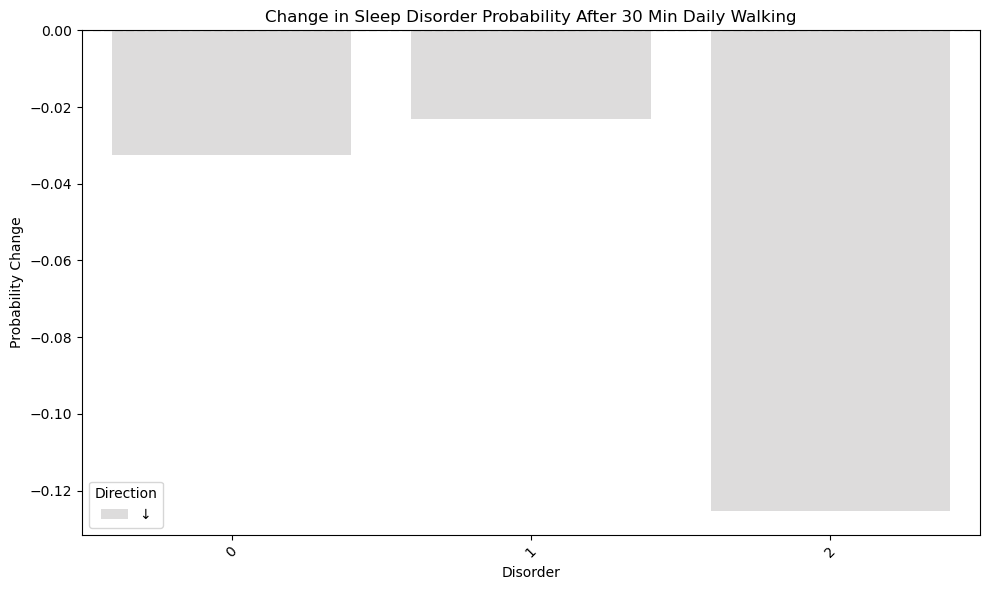


--- Prediction Table (Above Graph 2) ---
╒════════════╤════════════╤════════════════╕
│   Disorder │   Baseline │   Post-Walking │
╞════════════╪════════════╪════════════════╡
│          0 │  0.130008  │      0.0975062 │
├────────────┼────────────┼────────────────┤
│          1 │  0.0353796 │      0.0122233 │
├────────────┼────────────┼────────────────┤
│          2 │  0.834612  │      0.70942   │
╘════════════╧════════════╧════════════════╛


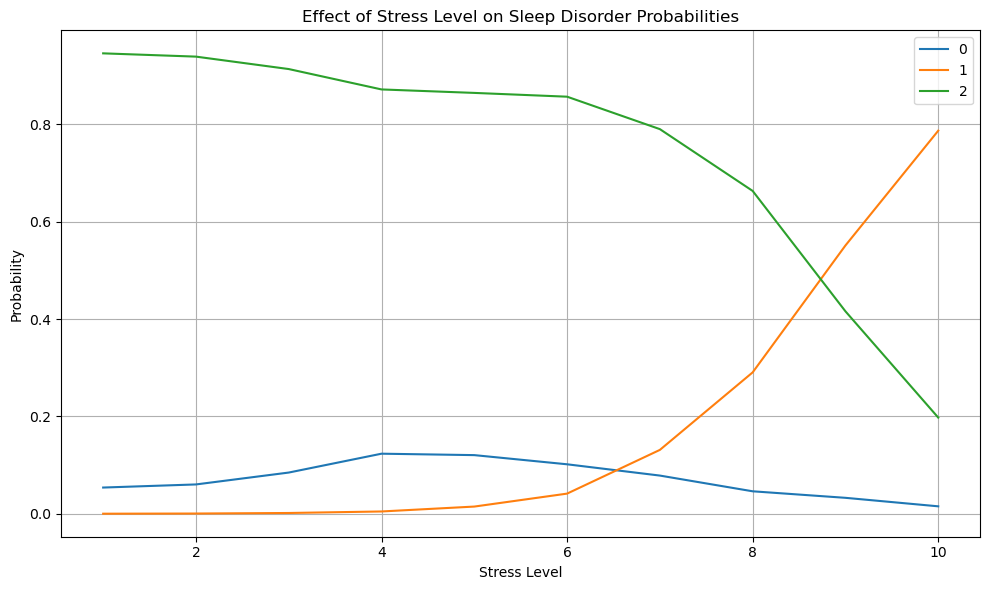


--- Change Summary (Above Graph 3) ---
╒════════════╤════════════╤════════════════╤═════════════╤═════════════╕
│   Disorder │   Baseline │   Intervention │ Change(%)   │ Direction   │
╞════════════╪════════════╪════════════════╪═════════════╪═════════════╡
│          0 │  0.130008  │      0.0975062 │ 3.25%       │ ↓           │
├────────────┼────────────┼────────────────┼─────────────┼─────────────┤
│          1 │  0.0353796 │      0.0122233 │ 2.32%       │ ↓           │
├────────────┼────────────┼────────────────┼─────────────┼─────────────┤
│          2 │  0.834612  │      0.70942   │ 12.52%      │ ↓           │
╘════════════╧════════════╧════════════════╧═════════════╧═════════════╛


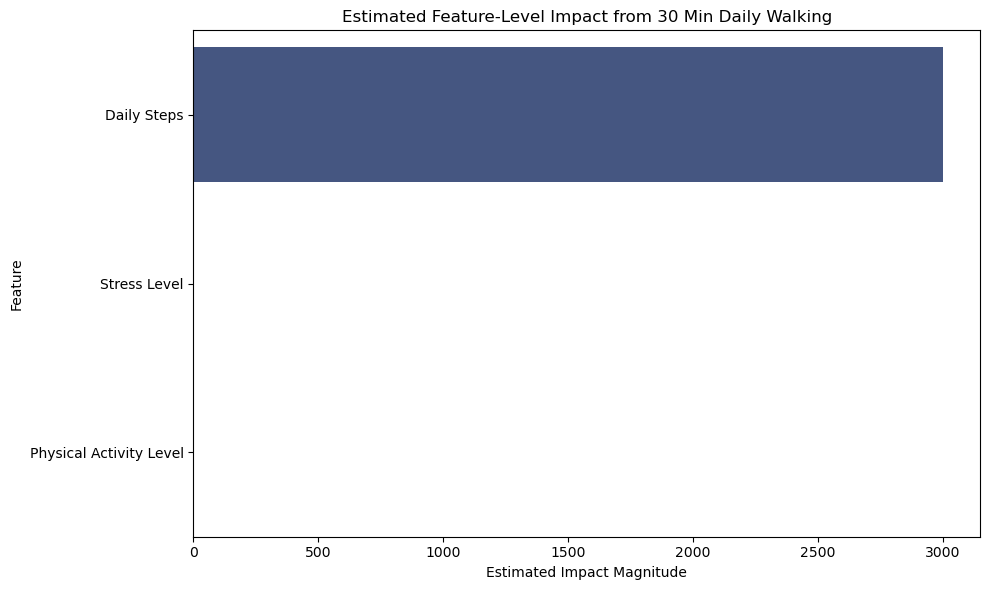

In [60]:
all_prob_df, prob_change = simulate_walking_impact_on_sleep(final_model, data, X_test_tensor, poly, scaler, le_target)